In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import uuid
import json
import copy

from scipy.stats import skewnorm, norm
from datetime import datetime, timedelta
from tqdm.notebook import tqdm
from rdflib import ConjunctiveGraph, Namespace, RDF, RDFS, URIRef, Literal
from pykeen.models.inductive import InductiveNodePieceGNN
from pykeen.training import SLCWATrainingLoop
from pykeen.evaluation.rank_based_evaluator import SampledRankBasedEvaluator
from pykeen.stoppers import EarlyStopper
from pykeen.triples import TriplesFactory
from pykeen.losses import MarginRankingLoss
from pykeen.predict import predict_target
from torch.optim import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

# Intracranial aneurysm ruptures prediction

### 1. Synthetic data generation

In [2]:
N_PATIENTS = 100

##### 1.1 Patients features

In [3]:
FEATURES = ["rupture", "sex", "age", "hta", "bmi", "sporadic_case", "multiple_IA", "IA_location", "adjusted_size_ratio", 
            "tobacco", "alcohol", "headaches", "diabetes", "dyslipidemia", "ischemic_stroke_history", 
            "ischemic_heart_disease_history", "pad_history", "carotid_artery_stenosis_history", "aortic_aneurysm_history", 
            "statin_ttt", "platelet_aggregation_inhibiting_ttt", "vka_or_anticoagulant_ttt", "anti_inflammatory_ttt", 
            "hormone_therapy_ttt", "allergy", "asthma", "atopy", "eczema"] 

In [4]:
def yes_no_var(percentage_yes, nb_samples) :
    return np.random.choice([1, 0], nb_samples, p=[percentage_yes, 1-percentage_yes])

In [5]:
np.random.seed(111)
df = pd.DataFrame()
nb_samples = N_PATIENTS
nb_choice = nb_samples * 5

for f in FEATURES :
    if "rupture" in f:
        df[f] = yes_no_var(0.397, nb_samples)
    
    if 'sex' in f:
        var = np.repeat(None, nb_samples)
        var[df[df.rupture == 1].index] = np.random.choice([1, 0], len(df[df.rupture == 1]), p=[0.30, 0.70])
        var[df[df.rupture == 0].index] = np.random.choice([1, 0], len(df[df.rupture == 0]), p=[0.27, 0.73])
        df[f] = var
        
    if 'age' in f:
        var = np.repeat(None, nb_samples)
        mean = 50.3 ; sd = 12.1 ; min_val = 18 ; max_val = 87
        random_nb = np.random.normal(loc = mean, scale = sd, size = nb_choice).astype(int)
        random_nb = random_nb[np.where((random_nb >= min_val)&(random_nb <= max_val))]
        var[df[df.rupture == 1].index] = np.random.choice(random_nb, size = len(df[df.rupture == 1]))
        mean = 55.8 ; sd = 11.9 ; min_val = 20 ; max_val = 85
        random_nb = np.random.normal(loc = mean, scale = sd, size = nb_choice).astype(int)
        random_nb_No = random_nb[np.where((random_nb >= min_val)&(random_nb <= max_val))]
        var[df[df.rupture == 0].index] = np.random.choice(random_nb, size = len(df[df.rupture == 0]))
        df[f] = var
        
    if 'sporadic_case' in f:
        var = np.repeat(None, nb_samples)
        var[df[df.rupture == 1].index] = yes_no_var(0.84, len(df[df.rupture == 1]))
        var[df[df.rupture == 0].index] = yes_no_var(0.81, len(df[df.rupture == 0]))
        df[f] = var
        
    if 'multiple_IA' in f:
        var = np.repeat(None, nb_samples)
        var[df[df.rupture == 1].index] = yes_no_var(0.34, len(df[df.rupture == 1]))
        var[df[df.rupture == 0].index] = yes_no_var(0.30, len(df[df.rupture == 0]))
        df[f] = var
        
    if "IA_location" in f:
        var = np.repeat(None, nb_samples)
        var[df[df.rupture == 1].index] = np.random.choice([0, 1, 2, 3], len(df[df.rupture == 1]), p=[0.12, 0.23, 0.39, 0.26])
        var[df[df.rupture == 0].index] = np.random.choice([0, 1, 2, 3], len(df[df.rupture == 0]), p=[0.33, 0.29, 0.24, 0.14])
        df[f] = var
        
    if 'adjusted_size_ratio' in f:
        select_indiv = []
        a = 2.27 ; loc = 0.97 ; scale = 1.29
        random_nb = skewnorm.rvs(a, loc, scale, size = nb_choice).round(decimals = 2)
        random_nb = random_nb[np.where(random_nb >=0.25)]
        size_ICA = np.random.choice(random_nb, size = len(df[df["IA_location"] == 0]))

        select_indiv = []
        a = 2.88 ; loc = 1.17 ; scale = 1.44
        random_nb = skewnorm.rvs(a, loc, scale, size = nb_choice).round(decimals = 2)
        random_nb = random_nb[np.where(random_nb >=0.33)]
        size_MCA = np.random.choice(random_nb, size = len(df[df["IA_location"] == 1]))

        select_indiv = []
        a = 7.52 ; loc = 3.05 ; scale = 4.04
        random_nb = skewnorm.rvs(a, loc, scale, size = nb_choice).round(decimals = 2)
        random_nb = random_nb[np.where(random_nb >=1)]
        size_ACA = np.random.choice(random_nb, size = len(df[df["IA_location"] == 2]))

        select_indiv = []
        a = 2.34 ; loc = 2.48 ; scale = 3.56
        random_nb = skewnorm.rvs(a, loc, scale, size = nb_choice).round(decimals = 2)
        random_nb = random_nb[np.where(random_nb >=0.66)]
        size_PCA = np.random.choice(random_nb, size = len(df[df["IA_location"] == 3]))

        size = np.repeat(-1.11, nb_samples)
        size[df[df["IA_location"] == 0].index] = size_ICA
        size[df[df["IA_location"] == 1].index] = size_MCA
        size[df[df["IA_location"] == 2].index] = size_ACA
        size[df[df["IA_location"] == 3].index] = size_PCA
        df[f] = size
        
    if "tobacco" in f:
        var = np.repeat(None, nb_samples)
        var[df[df.rupture == 1].index] = np.random.choice([0, 1, 2], len(df[df.rupture == 1]), p=[0.29, 0.46, 0.25])
        var[df[df.rupture == 0].index] = np.random.choice([0, 1, 2], len(df[df.rupture == 0]), p=[0.29, 0.42, 0.29])
        df[f] = var
    
    if "alcohol" in f:
        var = np.repeat(None, nb_samples)
        var[df[df.rupture == 1].index] = np.random.choice([0, 1], len(df[df.rupture == 1]), p=[0.87, 0.13])
        var[df[df.rupture == 0].index] = np.random.choice([0, 1], len(df[df.rupture == 0]), p=[0.89, 0.11])
        df[f] = var
        
    if "hta" in f:
        var = np.repeat(None, nb_samples)
        var[df[df.rupture == 1].index] = yes_no_var(0.36, len(df[df.rupture == 1]))
        var[df[df.rupture == 0].index] = yes_no_var(0.38, len(df[df.rupture == 0]))
        df[f] = var
        
    if "headaches" in f:
        var = np.repeat(None, nb_samples)
        var[df[(df.rupture == 1)&(df.hta == 1)].index] = yes_no_var(0.15, len(df[(df.rupture == 1)&(df.hta == 1)]))
        var[df[(df.rupture == 1)&(df.hta == 0)].index] = yes_no_var(0.15, len(df[(df.rupture == 1)&(df.hta == 0)]))
        var[df[(df.rupture == 0)&(df.hta == 1)].index] = yes_no_var(0.13, len(df[(df.rupture == 0)&(df.hta == 1)]))
        var[df[(df.rupture == 0)&(df.hta == 0)].index] = yes_no_var(0.22, len(df[(df.rupture == 0)&(df.hta == 0)]))
        df[f] = var
    
    if 'bmi' in f:
        means = [25.4, 0] # bmi N(25.4, 23.04) , diabetes N(0,1), cov(bmi, diabetes) = 3
        covs = [[23.04, 3],
                [3, 1]]
        
        # Generate data
        data = np.random.multivariate_normal(means, covs, nb_choice)
        random_bmi = data[:,0]
        random_diabetes = data[:,1]

        # Adjust mix and max values for bmi
        min_val = 15.6 ; max_val = 54.8
        mask = np.where((random_bmi >= min_val)&(random_bmi <= max_val))
        random_bmi = random_bmi[mask]
        random_diabetes = random_diabetes[mask]

        # Select the desired number of samples
        idxs = np.random.choice(np.arange(len(random_bmi)), nb_samples, replace=False)
        random_bmi = random_bmi[idxs]
        random_diabetes = random_diabetes[idxs]

        # Discretize the discrete diabetes variable
        mask1 = (df.hta == 0)&(random_diabetes >= norm.ppf(1 - 0.02))
        mask2 = (df.rupture == 1)&(df.hta == 1)&(random_diabetes >= norm.ppf(1 - 0.06))
        mask3 = (df.rupture == 0)&(df.hta == 1)&(random_diabetes >= norm.ppf(1 - 0.1))
        mask = mask1 | mask2 | mask3
        random_diabetes[mask] = 1
        random_diabetes[~mask] = 0

        df['bmi'] = random_bmi
        df['diabetes'] = random_diabetes
        
    if "dyslipidemia" in f:
        var = np.repeat(None, nb_samples)
        var[df[(df.rupture == 1)&(df.hta == 1)].index] = yes_no_var(0.30, len(df[(df.rupture == 1)&(df.hta == 1)]))
        var[df[(df.rupture == 1)&(df.hta == 0)].index] = yes_no_var(0.12, len(df[(df.rupture == 1)&(df.hta == 0)]))
        var[df[(df.rupture == 0)&(df.hta == 1)].index] = yes_no_var(0.40, len(df[(df.rupture == 0)&(df.hta == 1)]))
        var[df[(df.rupture == 0)&(df.hta == 0)].index] = yes_no_var(0.16, len(df[(df.rupture == 0)&(df.hta == 0)]))
        df[f] = var
    
    if "ischemic_stroke_history" in f:
        var = np.repeat(None, nb_samples)
        var[df[(df.rupture == 1)&(df.dyslipidemia == 1)].index] = yes_no_var(0.08, len(df[(df.rupture == 1)&(df.dyslipidemia == 1)]))
        var[df[(df.rupture == 1)&(df.dyslipidemia == 0)].index] = yes_no_var(0.02, len(df[(df.rupture == 1)&(df.dyslipidemia == 0)]))
        var[df[(df.rupture == 0)&(df.dyslipidemia == 1)].index] = yes_no_var(0.20, len(df[(df.rupture == 0)&(df.dyslipidemia == 1)]))
        var[df[(df.rupture == 0)&(df.dyslipidemia == 0)].index] = yes_no_var(0.07, len(df[(df.rupture == 0)&(df.dyslipidemia == 0)]))
        df[f] = var
        
    if "ischemic_heart_disease_history" in f:
        var = np.repeat(None, nb_samples)
        var[df[(df.rupture == 1)&(df.ischemic_stroke_history == 1)].index] = yes_no_var(0.09, len(df[(df.rupture == 1)&(df.ischemic_stroke_history == 1)]))
        var[df[(df.rupture == 1)&(df.ischemic_stroke_history == 0)].index] = yes_no_var(0.01, len(df[(df.rupture == 1)&(df.ischemic_stroke_history == 0)]))
        var[df[(df.rupture == 0)&(df.ischemic_stroke_history == 1)].index] = yes_no_var(0.12, len(df[(df.rupture == 0)&(df.ischemic_stroke_history == 1)]))
        var[df[(df.rupture == 0)&(df.ischemic_stroke_history == 0)].index] = yes_no_var(0.04, len(df[(df.rupture == 0)&(df.ischemic_stroke_history == 0)]))
        df[f] = var
        
    if "pad_history" in f:
        var = np.repeat(None, nb_samples)
        var[df[(df.rupture == 1)&(df.ischemic_heart_disease_history == 1)].index] = yes_no_var(0.33, len(df[(df.rupture == 1)&(df.ischemic_heart_disease_history == 1)]))
        var[df[(df.rupture == 1)&(df.ischemic_heart_disease_history == 0)].index] = yes_no_var(0.01, len(df[(df.rupture == 1)&(df.ischemic_heart_disease_history == 0)]))
        var[df[(df.rupture == 0)&(df.ischemic_heart_disease_history == 1)].index] = yes_no_var(0.16, len(df[(df.rupture == 0)&(df.ischemic_heart_disease_history == 1)]))
        var[df[(df.rupture == 0)&(df.ischemic_heart_disease_history == 0)].index] = yes_no_var(0.02, len(df[(df.rupture == 0)&(df.ischemic_heart_disease_history == 0)]))
        df[f] = var
        
    if "carotid_artery_stenosis_history" in f:
        df[f] = yes_no_var(0.03, nb_samples)
        
    if 'aortic_aneurysm_history' in f:
        df[f] = yes_no_var(0.005, nb_samples)
        
    if "statin_ttt" in f:
        var = np.repeat(None, nb_samples)
        var[df[(df.rupture == 1)&(df.dyslipidemia == 1)].index] = yes_no_var(0.46, len(df[(df.rupture == 1)&(df.dyslipidemia == 1)]))
        var[df[(df.rupture == 1)&(df.dyslipidemia == 0)].index] = yes_no_var(0.01, len(df[(df.rupture == 1)&(df.dyslipidemia == 0)]))
        var[df[(df.rupture == 0)&(df.dyslipidemia == 1)].index] = yes_no_var(0.39, len(df[(df.rupture == 0)&(df.dyslipidemia == 1)]))
        var[df[(df.rupture == 0)&(df.dyslipidemia == 0)].index] = yes_no_var(0.03, len(df[(df.rupture == 0)&(df.dyslipidemia == 0)]))
        df[f] = var
        
    if "platelet_aggregation_inhibiting_ttt" in f:
        var = np.repeat(None, nb_samples)
        var[df[(df.rupture == 1)&(df.ischemic_heart_disease_history == 1)].index] = yes_no_var(0.5, len(df[(df.rupture == 1)&(df.ischemic_heart_disease_history == 1)]))
        var[df[(df.rupture == 1)&(df.ischemic_heart_disease_history == 0)].index] = yes_no_var(0.09, len(df[(df.rupture == 1)&(df.ischemic_heart_disease_history == 0)]))
        var[df[(df.rupture == 0)&(df.ischemic_heart_disease_history == 1)].index] = yes_no_var(0.24, len(df[(df.rupture == 0)&(df.ischemic_heart_disease_history == 1)]))
        var[df[(df.rupture == 0)&(df.ischemic_heart_disease_history == 0)].index] = yes_no_var(0.13, len(df[(df.rupture == 0)&(df.ischemic_heart_disease_history == 0)]))
        df[f] = var
        
    if "vka_or_anticoagulant_ttt" in f:
        df[f] = yes_no_var(0.03, nb_samples)
        
    if "anti_inflammatory_ttt" in f:
        df[f] = yes_no_var(0.03, nb_samples)
        
    if 'hormone_therapy_ttt' in f:
        var = np.repeat(None, nb_samples)
        var[df[df.rupture == 1].index] = yes_no_var(0.02, len(df[df.rupture == 1]))
        var[df[df.rupture == 0].index] = yes_no_var(0.04, len(df[df.rupture == 0]))
        df[f] = var
    
    if "allergy" in f:
        var = np.repeat(None, nb_samples)
        var[df[df.rupture == 1].index] = yes_no_var(0.20, len(df[df.rupture == 1]))
        var[df[df.rupture == 0].index] = yes_no_var(0.25, len(df[df.rupture == 0]))
        df[f] = var
        
    if "asthma" in f:
        var = np.repeat(None, nb_samples)
        var[df[(df.rupture == 1)&(df.allergy == 1)].index] = yes_no_var(0.16, len(df[(df.rupture == 1)&(df.allergy == 1)]))
        var[df[(df.rupture == 1)&(df.allergy == 0)].index] = yes_no_var(0.03, len(df[(df.rupture == 1)&(df.allergy == 0)]))
        var[df[(df.rupture == 0)&(df.allergy == 1)].index] = yes_no_var(0.18, len(df[(df.rupture == 0)&(df.allergy == 1)]))
        var[df[(df.rupture == 0)&(df.allergy == 0)].index] = yes_no_var(0.04, len(df[(df.rupture == 0)&(df.allergy == 0)]))
        df[f] = var
        
    if "atopy" in f:
        var = np.repeat(None, nb_samples)
        var[df[(df.rupture == 1)&(df.allergy == 1)].index] = yes_no_var(0.15, len(df[(df.rupture == 1)&(df.allergy == 1)]))
        var[df[(df.rupture == 1)&(df.allergy == 0)].index] = yes_no_var(0.02, len(df[(df.rupture == 1)&(df.allergy == 0)]))
        var[df[(df.rupture == 0)&(df.allergy == 1)].index] = yes_no_var(0.14, len(df[(df.rupture == 0)&(df.allergy == 1)]))
        var[df[(df.rupture == 0)&(df.allergy == 0)].index] = yes_no_var(0.03, len(df[(df.rupture == 0)&(df.allergy == 0)]))
        df[f] = var
        
    if "eczema" in f:
        var = np.repeat(None, nb_samples)
        var[df[(df.rupture == 1)&(df.allergy == 1)].index] = yes_no_var(0.13, len(df[(df.rupture == 1)&(df.allergy == 1)]))
        var[df[(df.rupture == 1)&(df.allergy == 0)].index] = yes_no_var(0.04, len(df[(df.rupture == 1)&(df.allergy == 0)]))
        var[df[(df.rupture == 0)&(df.allergy == 1)].index] = yes_no_var(0.13, len(df[(df.rupture == 0)&(df.allergy == 1)]))
        var[df[(df.rupture == 0)&(df.allergy == 0)].index] = yes_no_var(0.04, len(df[(df.rupture == 0)&(df.allergy == 0)]))
        df[f] = var

In [6]:
df

,rupture,sex,age,hta,bmi,diabetes,sporadic_case,multiple_IA,IA_location,adjusted_size_ratio,...,aortic_aneurysm_history,statin_ttt,platelet_aggregation_inhibiting_ttt,vka_or_anticoagulant_ttt,anti_inflammatory_ttt,hormone_therapy_ttt,allergy,asthma,atopy,eczema
0,0,0,56,0,29.878520,0.0,1,0,2,9.00,...,0,0,0,0,0,0,0,1,0,0
1,1,1,43,0,27.010343,0.0,1,0,3,4.25,...,0,0,0,0,0,0,0,0,0,0
2,0,1,65,1,27.418302,0.0,1,0,0,1.16,...,0,0,0,0,0,0,0,0,0,0
3,0,0,32,0,23.786230,0.0,1,1,1,1.54,...,0,0,0,0,0,0,1,0,0,0
4,1,0,73,1,20.692629,0.0,1,0,2,4.19,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,0,22,1,33.395858,1.0,1,1,0,3.22,...,0,1,0,0,0,0,0,0,0,0
96,0,0,56,0,27.521322,0.0,1,0,0,1.34,...,0,0,0,0,0,0,1,0,1,0
97,0,0,82,1,20.732158,0.0,1,1,0,2.54,...,0,0,0,0,0,0,0,0,0,0
98,1,1,64,1,19.552180,0.0,1,1,2,4.08,...,0,0,1,0,0,0,0,0,0,0


In [7]:
df.to_csv('patient_data.csv', encoding='utf8', index = False) 

##### 1.2 Pathway

In [8]:
NVASC = Namespace("http://neurovasc#")
SPHN = Namespace("https://biomedit.ch/rdf/sphn-schema/sphn#")
TIME = Namespace("http://www.w3.org/2006/time#")

In [9]:
states = ["headache", "emergency", "samu", "transfer", "angiography", "occlusion", "clipping", "coiling", "flowDiverter", "web", 
           "back2home", "reabilitation", "death"]
classes = ["Headache", "Emergency", "SAMU", "Transfer", "Angiography", "Occlusion", "Clipping", "Coiling", "FlowDiverter", "Web", 
           "Back2Home", "Reabilitation", "Death"]
sphn_classes = ["", "", "", "", "ImagingProcedure", "MedicalProcedure", "MedicalProcedure", "MedicalProcedure", "MedicalProcedure", "MedicalProcedure", 
           "", "", ""]

map_ont_classes = {}
for i in range(0, len(states)):
    map_ont_classes[states[i]] = [classes[i], sphn_classes[i]]

In [10]:
def gen_start_event(y_min=2020, y_max=2023):
    n_days = (y_max - y_min) * 365
    d0 = datetime.fromisoformat(f"{y_min}-01-01")
    day_rand = round(np.random.uniform(n_days))
    delta = timedelta(days=day_rand)
    d_out = d0 + delta
    return(d_out)

print(gen_start_event())

2021-05-16 00:00:00


In [11]:
def gen_care_step(plan, label, d1, d2):
    g = ConjunctiveGraph()
    g.bind("nvasc", NVASC)
    g.bind("sphn", SPHN)
    g.bind("time", TIME)
    
    uid = uuid.uuid4()
    uri = URIRef(str(NVASC)+str(uid))

    classes = map_ont_classes[label]
    activity_class = URIRef(str(NVASC)+str(classes[0]))
    
    g.add((uri, RDF.type, activity_class))
    g.add((uri, RDF.type, TIME.ProperInterval))
    if classes[1] != "":
        g.add((uri, RDF.type, URIRef(str(SPHN)+str(classes[1]))))
    g.add((uri, SPHN.hasStartDateTime, Literal(d1)))
    g.add((uri, SPHN.hasEndDateTime, Literal(d2)))
    g.add((uri, RDFS.label, Literal(label)))
    if plan:
        g.add((uri, SPHN.hasSubjectPseudoIdentifier, plan))
    return g, uri

In [12]:
d1 = gen_start_event()
pred = URIRef(str(NVASC)+str(uuid.uuid4()))
d2 = gen_start_event()
g, uri = gen_care_step(NVASC.p1, "angiography", d1, d2)
print(g.serialize(format="turtle"))
print(uri)

@prefix nvasc: <http://neurovasc#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix sphn: <https://biomedit.ch/rdf/sphn-schema/sphn#> .
@prefix time: <http://www.w3.org/2006/time#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

nvasc:d1e6df1a-ae0e-4662-bbf3-e879375337f3 a nvasc:Angiography,
        time:ProperInterval,
        sphn:ImagingProcedure ;
    rdfs:label "angiography" ;
    sphn:hasEndDateTime "2022-07-23T00:00:00"^^xsd:dateTime ;
    sphn:hasStartDateTime "2022-04-02T00:00:00"^^xsd:dateTime ;
    sphn:hasSubjectPseudoIdentifier nvasc:p1 .


http://neurovasc#d1e6df1a-ae0e-4662-bbf3-e879375337f3


In [13]:
def gen_patient_info(plan):
    g = ConjunctiveGraph()
    g.bind("nvasc", NVASC)
    g.bind("sphn", SPHN)
    
    uri = URIRef(str(plan))

    # Patient
    activity_class = URIRef(str(SPHN) + "SubjectPseudoIdentifier")
    patient_id = plan.split('#')[1]
    patient_num = int(patient_id.split('_')[1])
    g.add((uri, RDF.type, activity_class))
    g.add((uri, SPHN.hasIdentifier, Literal(patient_id)))

    # Age
    q1_class = URIRef(str(SPHN) + "Quantity")
    q1_uri = URIRef(str(NVASC)+str(uuid.uuid4()))
    g.add((q1_uri, RDF.type, q1_class))
    g.add((q1_uri, SPHN.hasValue, Literal(df.iloc[patient_num]['age'])))
    g.add((q1_uri, RDFS.label, Literal("Quantity")))
    age_class = URIRef(str(SPHN) + "Age")
    age_uri = URIRef(str(NVASC)+str(uuid.uuid4()))
    g.add((age_uri, RDF.type, age_class))
    g.add((age_uri, SPHN.hasQuantity, q1_uri))
    g.add((age_uri, SPHN.hasSubjectPseudoIdentifier, plan))
    g.add((age_uri, RDFS.label, Literal("Age_"+patient_id)))
    
    # BMI
    q2_class = URIRef(str(SPHN) + "Quantity")
    q2_uri = URIRef(str(NVASC)+str(uuid.uuid4()))
    g.add((q2_uri, RDF.type, q2_class))
    g.add((q2_uri, SPHN.hasValue, Literal(df.iloc[patient_num]['bmi'])))
    g.add((q2_uri, RDFS.label, Literal("Quantity")))
    bmi_class = URIRef(str(SPHN) + "BodyMassIndex")
    bmi_uri = URIRef(str(NVASC)+str(uuid.uuid4()))
    g.add((bmi_uri, RDF.type, bmi_class))
    g.add((bmi_uri, SPHN.hasQuantity, q2_uri))
    g.add((bmi_uri, SPHN.hasSubjectPseudoIdentifier, plan))
    g.add((bmi_uri, RDFS.label, Literal("BMI_"+patient_id)))

    # Sex
    sex_class = URIRef(str(SPHN) + "AdministrativeSex")
    sex_uri = URIRef(str(NVASC)+str(uuid.uuid4()))
    g.add((sex_uri, RDF.type, sex_class))
    g.add((sex_uri, SPHN.hasCode, Literal(df.iloc[patient_num]['sex'])))
    g.add((sex_uri, SPHN.hasSubjectPseudoIdentifier, plan))
    g.add((sex_uri, RDFS.label, Literal("Sex_"+patient_id)))

    # Adjusted Size Ratio
    q3_class = URIRef(str(SPHN) + "Quantity")
    q3_uri = URIRef(str(NVASC)+str(uuid.uuid4()))
    g.add((q3_uri, RDF.type, q3_class))
    g.add((q3_uri, SPHN.hasValue, Literal(df.iloc[patient_num]['adjusted_size_ratio'])))
    g.add((q3_uri, RDFS.label, Literal("Quantity")))
    asr_class = URIRef(str(SPHN) + "BodySurfaceArea")
    asr_uri = URIRef(str(NVASC)+str(uuid.uuid4()))
    g.add((asr_uri, RDF.type, asr_class))
    g.add((asr_uri, SPHN.hasQuantity, q3_uri))
    g.add((asr_uri, SPHN.hasSubjectPseudoIdentifier, plan))
    g.add((asr_uri, RDFS.label, Literal("Adjusted_Size_Ratio_"+patient_id)))

    # Rest of features
    for feature in set(FEATURES) - set(["age", "bmi", "sex", "adjusted_size_ratio"]):
        f_class = URIRef(str(SPHN) + "Diagnosis")
        f_uri = URIRef(str(NVASC)+str(uuid.uuid4()))
        g.add((f_uri, RDF.type, f_class))
        g.add((f_uri, SPHN.hasCode, Literal(df.iloc[patient_num][feature])))
        g.add((f_uri, SPHN.hasSubjectPseudoIdentifier, plan))
        g.add((f_uri, RDFS.label, Literal(feature+"_"+patient_id)))

    return g, uri

In [14]:
g, uri = gen_patient_info(NVASC.Patient_0)
print(g.serialize(format="turtle"))
print(uri)

@prefix nvasc: <http://neurovasc#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix sphn: <https://biomedit.ch/rdf/sphn-schema/sphn#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

nvasc:0719937c-c8a3-4cbc-aeaf-9d4150b4920d a sphn:Diagnosis ;
    rdfs:label "statin_ttt_Patient_0" ;
    sphn:hasCode 0 ;
    sphn:hasSubjectPseudoIdentifier nvasc:Patient_0 .

nvasc:1023bef9-13c1-46b5-80ca-d4c2ee96403d a sphn:Diagnosis ;
    rdfs:label "platelet_aggregation_inhibiting_ttt_Patient_0" ;
    sphn:hasCode 0 ;
    sphn:hasSubjectPseudoIdentifier nvasc:Patient_0 .

nvasc:2b25059d-fa9a-437f-aba2-1069d71cce78 a sphn:BodySurfaceArea ;
    rdfs:label "Adjusted_Size_Ratio_Patient_0" ;
    sphn:hasQuantity nvasc:523a30aa-0fe9-4d5d-b02e-3f0e5f6897a5 ;
    sphn:hasSubjectPseudoIdentifier nvasc:Patient_0 .

nvasc:33de826b-e05d-45ae-bcc8-b49cb5d6d523 a sphn:Diagnosis ;
    rdfs:label "IA_location_Patient_0" ;
    sphn:hasCode 2 ;
    sphn:hasSubjectPseudoIdentifier nvasc:Patient_0 

In [15]:
class MarkovChain_mat_time(object):
    def __init__(self, transition_matrix, states, timing):
        """
        Initialize the MarkovChain instance.
        """
        self.transition_matrix = np.atleast_2d(transition_matrix)
        self.states = states
        self.timing = timing
        self.index_dict = {self.states[index]: index for index in 
                           range(len(self.states))}
        self.state_dict = {index: self.states[index] for index in
                           range(len(self.states))}
        self.kg = ConjunctiveGraph()
 
    def next_state(self, current_state, current_timepoint):
        """
        Returns the state of the random variable at the next time 
        instance, and the next timepoint. 
        """
        
        duration_h = np.random.uniform(low=self.timing[current_state][0], high=self.timing[current_state][1])
        delta = timedelta(hours = duration_h)
        
        next_timepoint = current_timepoint + delta
        
        return (
            np.random.choice(
                self.states, 
                p=self.transition_matrix[self.index_dict[current_state], :]
            ), 
            next_timepoint
        )
 
    def generate_states(self, id, current_state, no=10, all_outputs=False):
        """
        Generates the next states of the system.
        """
        source_dest = []
        future_states = []
        current_time = gen_start_event()

        g, uri_pred = gen_care_step(URIRef(str(NVASC)+id), current_state, current_time, current_time)
        self.kg += g
        states_uris = [uri_pred]
        
        for i in range(no):
            next_state, next_time = self.next_state(current_state, current_time)
            final = next_state in states[-3:]
            if (next_state != current_state and not all_outputs) or (all_outputs and not final):
                g, uri = gen_care_step(URIRef(str(NVASC)+id), next_state, current_time, next_time)
                
                self.kg += g
                future_states.append((next_state,  next_time.strftime("%Y-%m-%d %H:%M:%S")))
                source_dest.append([current_state, next_state])
                states_uris.append(uri)
                
                current_state = next_state
                current_time = next_time
                uri_pred = uri
            else :
                if all_outputs:
                    y_test.append(states[-3:].index(next_state))
                    for s in states[-3:]:
                        g, uri = gen_care_step(None, s, current_time, next_time)
                        self.kg += g
                        states_uris.append(uri)

                self.kg += gen_patient_info(URIRef(str(NVASC)+id))[0]
                return future_states, source_dest, self.kg, states_uris
                
        return future_states, source_dest

In [16]:
def add_temporal_relations(kg, uris, level):
    for i in range(len(uris) - 1):
        kg.add((uris[i], TIME.intervalMeets, uris[i+1]))

    if level == 2:
        for i in range(len(uris)-1, 0, -1):
            kg.add((uris[i], TIME.intervalMetBy, uris[i-1]))
        
        for i in range(len(uris) - 1):
            for j in range(i+2, len(uris)):
                kg.add((uris[i], TIME.intervalBefore, uris[j]))
        
        for i in range(len(uris)-1, 0, -1):
            for j in range(i-2, -1, -1):
                kg.add((uris[i], TIME.intervalAfter, uris[j]))
    
    elif level == 3:
        for i in range(len(uris) - 2):
            kg.add((uris[i], TIME.intervalBefore, uris[i+2]))

In [17]:
with open("../data/transition_parameters.json") as js:
    params = json.load(js)
transition_matrix = np.zeros((13, 13))
transition_matrix[0, 1:4] = params["headaches"]
transition_matrix[1:4] = [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
transition_matrix[4, 5:10] = params["angiography"]
transition_matrix[5, 10:] = params["occlusion"]
transition_matrix[6, 10:] = params["clipping"]
transition_matrix[7, 10:] = params["coiling"]
transition_matrix[8, 10:] = params["flowDiverter"]
transition_matrix[9, 10:] = params["web"]
transition_matrix[10, 10] = 1
transition_matrix[11, 11] = 1
transition_matrix[12, 12] = 1

In [18]:
timing = {}
timing['headache'] = (1, 168)
timing['emergency'] = (1, 24)
timing['samu'] = (1, 24)
timing['transfer'] = (1, 24)
timing['angiography'] = (1, 24)
timing['occlusion'] = (1, 48)
timing['clipping'] = (1, 48)
timing['coiling'] = (1, 48)
timing['flowDiverter'] = (1, 48)
timing['web'] = (1, 48)
timing['back2home'] = (1, 1)
timing['reabilitation'] = (1, 1)
timing['death'] = (1, 1)

### 2. Creating train/test files

In [19]:
stroke_pathway = MarkovChain_mat_time(
    transition_matrix=transition_matrix,
    states=states, 
    timing=timing)

d = []
kg = ConjunctiveGraph()
kg.bind("nvasc", NVASC)
kg.bind("sphn", SPHN)
temp_uris = []
training_size = int(0.8 * nb_samples)

for i in tqdm(range(0, training_size)):
    start = gen_start_event()
    pws, source_dest, g, states_uris = stroke_pathway.generate_states(f'Patient_{i}','headache', 10)
    kg += g
    temp_uris += [states_uris]
    for pw in pws:
        row = (f"Patient_{i}",pw[0], pw[1])
        d.append(row)
    
df_path = pd.DataFrame(d, columns=('Patient_ID', 'Exam', 'Date'))

df_path.to_csv("pathway_data_train.csv")

for i in range(1, 4):
    kg_temp = copy.deepcopy(kg)
    for p in range(training_size):
        add_temporal_relations(kg_temp, temp_uris[p], level=i)
    with open(f"graph_sphn_{i}_train.xml", "w") as text_file:
        text_file.write(kg_temp.serialize(format="nt").replace(" .\n", "\n").replace(" ", "\t"))
    with open(f"graph_sphn_{i}_train.ttl", "w") as text_file:
        text_file.write(kg_temp.serialize(format="ttl"))
    print(f"{len(kg_temp)} triples in the knowledge graph")

  0%|          | 0/80 [00:00<?, ?it/s]

12720 triples in the knowledge graph
14000 triples in the knowledge graph
12960 triples in the knowledge graph


In [20]:
stroke_pathway = MarkovChain_mat_time(
    transition_matrix=transition_matrix,
    states=states, 
    timing=timing)

d = []
kg = ConjunctiveGraph()
kg.bind("nvasc", NVASC)
kg.bind("sphn", SPHN)
temp_uris = []
y_test = []

for i in tqdm(range(training_size, nb_samples)):
    start = gen_start_event()
    pws, source_dest, g, states_uris = stroke_pathway.generate_states(f'Patient_{i}','headache', 10, all_outputs=True)
    kg += g
    temp_uris += [states_uris]
    for pw in pws:
        row = (f"Patient_{i}",pw[0], pw[1])
        d.append(row)
    
df_path = pd.DataFrame(d, columns=('Patient_ID', 'Exam', 'Date'))

df_path.to_csv("pathway_data_test.csv")

for i in range(1, 4):
    kg_temp = copy.deepcopy(kg)
    for p in range(training_size, nb_samples):
        add_temporal_relations(kg_temp, temp_uris[p-training_size][:4], level=i)
    with open(f"graph_sphn_{i}_test.xml", "w") as text_file:
        text_file.write(kg_temp.serialize(format="nt").replace(" .\n", "\n").replace(" ", "\t"))
    with open(f"graph_sphn_{i}_test.ttl", "w") as text_file:
        text_file.write(kg_temp.serialize(format="ttl"))
    print(f"{len(kg_temp)} triples in the knowledge graph")

  0%|          | 0/20 [00:00<?, ?it/s]

3340 triples in the knowledge graph
3520 triples in the knowledge graph
3380 triples in the knowledge graph


### 3. Training the models

In [21]:
VERSION = 3

In [22]:
torch.cuda.is_available()

/home/ameginag/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


False

In [23]:
training = TriplesFactory.from_path(
    path = f"./graph_sphn_{VERSION}_train.xml",
    create_inverse_triples=True,
)

testing = TriplesFactory.from_path(
    path = f"./graph_sphn_{VERSION}_test.xml", 
    relation_to_id=training.relation_to_id,
)

In [24]:
model = InductiveNodePieceGNN(
    triples_factory=training,
    inference_factory=testing,
    num_tokens=12,
    aggregation="mlp",
    loss=MarginRankingLoss,
    random_seed=42,
    gnn_encoder=None,
)

optimizer = Adam(params=model.parameters(), lr=0.0005)

training_loop = SLCWATrainingLoop(
    triples_factory=training,
    model=model,
    optimizer=optimizer,
    negative_sampler_kwargs=dict(num_negs_per_pos=32),
    mode="training",
)

valid_evaluator = SampledRankBasedEvaluator(
    mode="validation",
    evaluation_factory=testing,
    additional_filter_triples=testing.mapped_triples,
)

test_evaluator = SampledRankBasedEvaluator(
    mode="testing",
    evaluation_factory=testing,
    additional_filter_triples=testing.mapped_triples,
)

early_stopper = EarlyStopper(
    model=model,
    training_triples_factory=testing,
    evaluation_triples_factory=testing,
    frequency=1,
    patience=100000,
    result_tracker=None,
    evaluation_batch_size=256,
    evaluator=valid_evaluator,
)

training_loop.train(
    triples_factory=training,
    stopper=early_stopper,
    num_epochs=10,
)

result = test_evaluator.evaluate(
    model=model,
    mapped_triples=testing.mapped_triples,
    additional_filter_triples=testing.mapped_triples,
    batch_size=256,
)

print(result.to_flat_dict())

sampling:   0%|          | 0.00/5.91k [00:00<?, ?it/s]

No symbolic computation of output shape.


sampling:   0%|          | 0.00/1.56k [00:00<?, ?it/s]

No symbolic computation of output shape.


Training epochs on cpu:   0%|          | 0/10 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/101 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/3.38k [00:00<?, ?triple/s]

Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).


Training batches on cpu:   0%|          | 0/101 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/3.38k [00:00<?, ?triple/s]

Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).


Training batches on cpu:   0%|          | 0/101 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/3.38k [00:00<?, ?triple/s]

Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).


Training batches on cpu:   0%|          | 0/101 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/3.38k [00:00<?, ?triple/s]

Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).


Training batches on cpu:   0%|          | 0/101 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/3.38k [00:00<?, ?triple/s]

Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).


Training batches on cpu:   0%|          | 0/101 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/3.38k [00:00<?, ?triple/s]

Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).


Training batches on cpu:   0%|          | 0/101 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/3.38k [00:00<?, ?triple/s]

Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).


Training batches on cpu:   0%|          | 0/101 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/3.38k [00:00<?, ?triple/s]

Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).


Training batches on cpu:   0%|          | 0/101 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/3.38k [00:00<?, ?triple/s]

Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).


Training batches on cpu:   0%|          | 0/101 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/3.38k [00:00<?, ?triple/s]

Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).


Evaluating on cpu:   0%|          | 0.00/3.38k [00:00<?, ?triple/s]

Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).


{'head.optimistic.adjusted_arithmetic_mean_rank_index': 0.824698224852071, 'tail.optimistic.adjusted_arithmetic_mean_rank_index': 0.9434674556213019, 'both.optimistic.adjusted_arithmetic_mean_rank_index': 0.8840828402366865, 'head.realistic.adjusted_arithmetic_mean_rank_index': 0.8246804809570313, 'tail.realistic.adjusted_arithmetic_mean_rank_index': 0.9433846187591552, 'both.realistic.adjusted_arithmetic_mean_rank_index': 0.8840325450897217, 'head.pessimistic.adjusted_arithmetic_mean_rank_index': 0.8246627218934912, 'tail.pessimistic.adjusted_arithmetic_mean_rank_index': 0.943301775147929, 'both.pessimistic.adjusted_arithmetic_mean_rank_index': 0.8839822485207101, 'head.optimistic.z_inverse_harmonic_mean_rank': 151.69121720973612, 'tail.optimistic.z_inverse_harmonic_mean_rank': 258.6669119204939, 'both.optimistic.z_inverse_harmonic_mean_rank': 290.16701582301044, 'head.realistic.z_inverse_harmonic_mean_rank': 151.61670161373348, 'tail.realistic.z_inverse_harmonic_mean_rank': 258.58284

### 4. Evaluation

In [25]:
result.get_metric('hits_at_10')

0.8766272189349112

In [26]:
# For all test patients get link prediction scores
preds = []
for i in range(len(y_test)):
    pred = predict_target(
        model=model,
        tail=f"<http://neurovasc#Patient_{training_size + i}>",
        relation="<https://biomedit.ch/rdf/sphn-schema/sphn#hasSubjectPseudoIdentifier>",
        triples_factory=testing,
        mode="testing",
    )
    pred.filter_triples(testing)
    preds += [pred]

# From predicted links compute the output with the most score as the model prediction
y_pred = [
    np.argmin(
        [pred.df['head_label'][pred.df['head_label'] == f'<{p[-3:][output]}>'].index[0] for output in range(3)]
        ) 
    for pred, p in zip(preds, temp_uris)
    ]

In [27]:
print(y_pred)
print(y_test)

[0, 2, 0, 0, 2, 2, 1, 1, 2, 1, 1, 1, 2, 0, 0, 2, 2, 1, 2, 0]
[1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0]


In [28]:
matrix = confusion_matrix(y_test, y_pred)

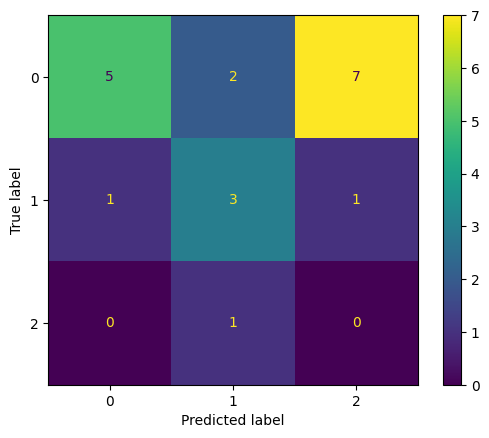

In [29]:
disp = ConfusionMatrixDisplay(confusion_matrix=matrix) 
disp.plot()
plt.show()

In [30]:
precision = precision_score(y_test, y_pred, average="macro")
print("Precision:", precision)
recall = recall_score(y_test, y_pred, average="macro")
print("Recall:", recall)
f1 = f1_score(y_test, y_pred, average="macro")
print("F1 Score:", f1)

Precision: 0.4444444444444445
Recall: 0.319047619047619
F1 Score: 0.34848484848484845
